In [ ]:
# You need to install the python Weaviate client
!pip install weaviate-client

## Download data
Download data from [drive](https://drive.google.com/file/d/1oOv6zT7_whFE78fUzo8hi64_FWO6-l44/view?usp=sharing)

## ☁️☁️ Configure the Weaviate Cloud Instance ☁️☁️
### Free 14 day sandbox here: https://console.weaviate.cloud/

In [20]:
import os
import weaviate
import json
import nomic
from nomic import atlas, AtlasProject
import numpy as np

auth_config = weaviate.auth.AuthApiKey(api_key='QX6qEW5KywFyZzXFQNkry64KVwQq8ugiOTcU')

client = weaviate.Client(
    url="https://workshop-test-b60l5wap.weaviate.network",
    auth_client_secret=auth_config,
)

client.is_ready()

True

## ䷀䷀Create Database Schema䷀䷀

In [ ]:
# delete existing schema, (note, this will delete all your weaviate data)
#client.schema.delete_all()

article_schema = {
    "class": "Article",
    "description": "Wiki Article",
    
    "vectorizer": "text2vec-cohere", #the translator to convert from text to vec
    
    "moduleConfig": {
        "text2vec-cohere": {
            "model": "multilingual-22-12", #multilingual 
            "truncate": "RIGHT"
        }, 
        "generative-openai":{},
    },
    "vectorIndexConfig": {
        "distance": "dot"
    },
    
    "properties": [
    {
        "name": "text",
        "dataType": [ "text" ],
        "description": "Article body",
        "moduleConfig": {
            "text2vec-cohere": {
                "skip": False,
                "vectorizePropertyName": False
            }
        }
    },
    {
        "name": "title",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "url",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "wiki_id",
        "dataType": [ "int" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "views",
        "dataType": [ "number" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    ]
}

# add the schema
#client.schema.delete_all()
client.schema.create_class(article_schema)

print("The schema has been created")

In [ ]:
client.schema.get()

In [21]:
import pandas as pd
df = pd.read_parquet('wiki_simple_100k.parquet')

In [22]:
df.sample(5)

id                  title  \
14180  14180               December   
71754  71754  Antibiotic resistance   
90406  90406                Marburg   
9235    9235         Roman numerals   
22636  22636   James Prescott Joule   

                                                    text  \
14180  December begins on the same day of the week as...   
71754  combination of two drugs, artemether-lumefantr...   
90406  The upper part of Old town, near the castle an...   
9235   It is very easy to write a number as a Roman n...   
22636  Kinetics is the science of motion. Joule was a...   

                                                  url  wiki_id       views  \
14180     https://simple.wikipedia.org/wiki?curid=185      185  271.238037   
71754  https://simple.wikipedia.org/wiki?curid=366966   366966   49.827438   
90406   https://simple.wikipedia.org/wiki?curid=17921    17921   35.010708   
9235     https://simple.wikipedia.org/wiki?curid=7641     7641  364.596527   
22636   https://simple.wikipedia.org/wiki?curid=29213    29213  188.147720   

       paragraph_id  langs                                                emb  
14180             3    252  [0.3499060869216919, 0.8032940030097961, 0.051...  
71754            21     51  [-0.15138965845108032, 0.35137122869491577, -0...  
90406             1     76  [0.14141567051410675, 0.03710193186998367, -0....  
9235              5    103  [-0.09458529204130173, 0.1241791769862175, -0....  
22636             2    113  [0.8221997022628784, -0.1636316329240799, -0.1...

In [9]:
df['emb'][0].shape

(768,)

## 💽💽 Batch and Add 100k Wikipedia Articles to Weaviate 💽💽

In [ ]:
### Step 1 - configure Weaviate Batch, which optimizes CRUD operations in bulk
# - starting batch size of 100
# - dynamically increase/decrease based on performance
# - add timeout retries if something goes wrong

client.batch.configure(
    batch_size=200,
    dynamic=True,
    timeout_retries=3,
)

In [ ]:
data = df[:100000] # make sure it is not more than 100k objects

counter=0

with client.batch as batch:
    for idx, item in data.iterrows():        
        # print update message every 100 objects        
        if (counter %100 == 0):
            print(f"Import {counter} / {len(data)} ", end="\r")

        properties = {
        "text": item["text"],
        "title": item["title"],
        "url": item["url"],
        "views": item["views"],
        "wiki_id": item["wiki_id"]
        }

        vector = item["emb"]

        batch.add_data_object(properties, "Article", None, vector)
        counter = counter+1
    print(f"Import {counter} / {len(data)}")
        
print("Import complete")

In [ ]:
# Test that all data has loaded – get object count
result = (
    client.query.aggregate("Article")
    .with_meta_count()
    .do()
)
print("Object count: ", result["data"]["Aggregate"]["Article"])

In [3]:
nomic.login("NOMIC_API_KEY")

In [9]:
schema = client.schema.get()

classes = []
props = []
for c in schema["classes"]:
    classes.append(c["class"])
    temp = []
    for p in c["properties"]:
        if p["dataType"] == ["text"]:
            temp.append(p["name"])
    props.append(temp)

In [10]:
def get_batch_with_cursor(
    client, class_name, class_properties, batch_size, cursor=None
):
    query = (
        client.query.get(class_name, class_properties)
        .with_additional(["vector", "id"])
        .with_limit(batch_size)
    )

    if cursor is not None:
        return query.with_after(cursor).do()
    else:
        return query.do()

In [15]:
c = 'Article'
p = ['text']

2023-12-13 18:44:22.723 | INFO     | nomic.project:_create_project:797 - Creating project `Article` in organization `weaviate`


In [11]:
project = AtlasProject(
    name=c,
    unique_id_field="id",
    modality="embedding",
)

Exception: Failed to find project: {"detail":[{"loc":["body","project_name"],"msg":"str type expected","type":"type_error.str"}]}

In [16]:
cursor = None
while True:
    response = get_batch_with_cursor(client, c, p, 10000, cursor)
    if len(response["data"]["Get"][c]) == 0:
        break
    cursor = response["data"]["Get"][c][-1]["_additional"]["id"]
    vectors = []
    for i in response["data"]["Get"][c]:
        vectors.append(i["_additional"]["vector"])

    embeddings = np.array(vectors)
    data = []
    not_data = ["_additional"]
    un_data = ["vector"]
    for i in response["data"]["Get"][c]:
        j = {key: value for key, value in i.items() if key not in not_data}
        k = {
            key: value
            for key, value in i["_additional"].items()
            if key not in un_data
        }
        j = j | k
        data.append(j)
    with project.wait_for_project_lock():
        project.add_embeddings(
            embeddings=embeddings,
            data=data,
        )

100%|█████████████████████████████████████████████| 2/2 [00:12<00:00,  6.43s/it]
2023-12-13 18:44:54.473 | INFO     | nomic.project:_add_data:1426 - Upload succeeded.
100%|█████████████████████████████████████████████| 2/2 [00:13<00:00,  6.78s/it]
2023-12-13 18:45:23.846 | INFO     | nomic.project:_add_data:1426 - Upload succeeded.
100%|█████████████████████████████████████████████| 2/2 [00:15<00:00,  7.73s/it]
2023-12-13 18:45:55.591 | INFO     | nomic.project:_add_data:1426 - Upload succeeded.
100%|█████████████████████████████████████████████| 2/2 [00:13<00:00,  6.65s/it]
2023-12-13 18:46:24.325 | INFO     | nomic.project:_add_data:1426 - Upload succeeded.
100%|█████████████████████████████████████████████| 2/2 [00:12<00:00,  6.42s/it]
2023-12-13 18:46:52.532 | INFO     | nomic.project:_add_data:1426 - Upload succeeded.
100%|█████████████████████████████████████████████| 2/2 [00:13<00:00,  6.93s/it]
2023-12-13 18:47:22.060 | INFO     | nomic.project:_add_data:1426 - Upload succeeded

In [18]:
project.create_index(
    name=c,
    colorable_fields=[p],
    build_topic_model=True,
)

2023-12-13 18:53:50.643 | INFO     | nomic.project:create_index:1135 - Created map `Article` in project `Article`: https://atlas.nomic.ai/map/35577daa-dfcf-41ec-b968-547bd36ccb09/cfff2edd-ab73-4f89-9fec-66fd86224e87


Article: https://atlas.nomic.ai/map/35577daa-dfcf-41ec-b968-547bd36ccb09/cfff2edd-ab73-4f89-9fec-66fd86224e87

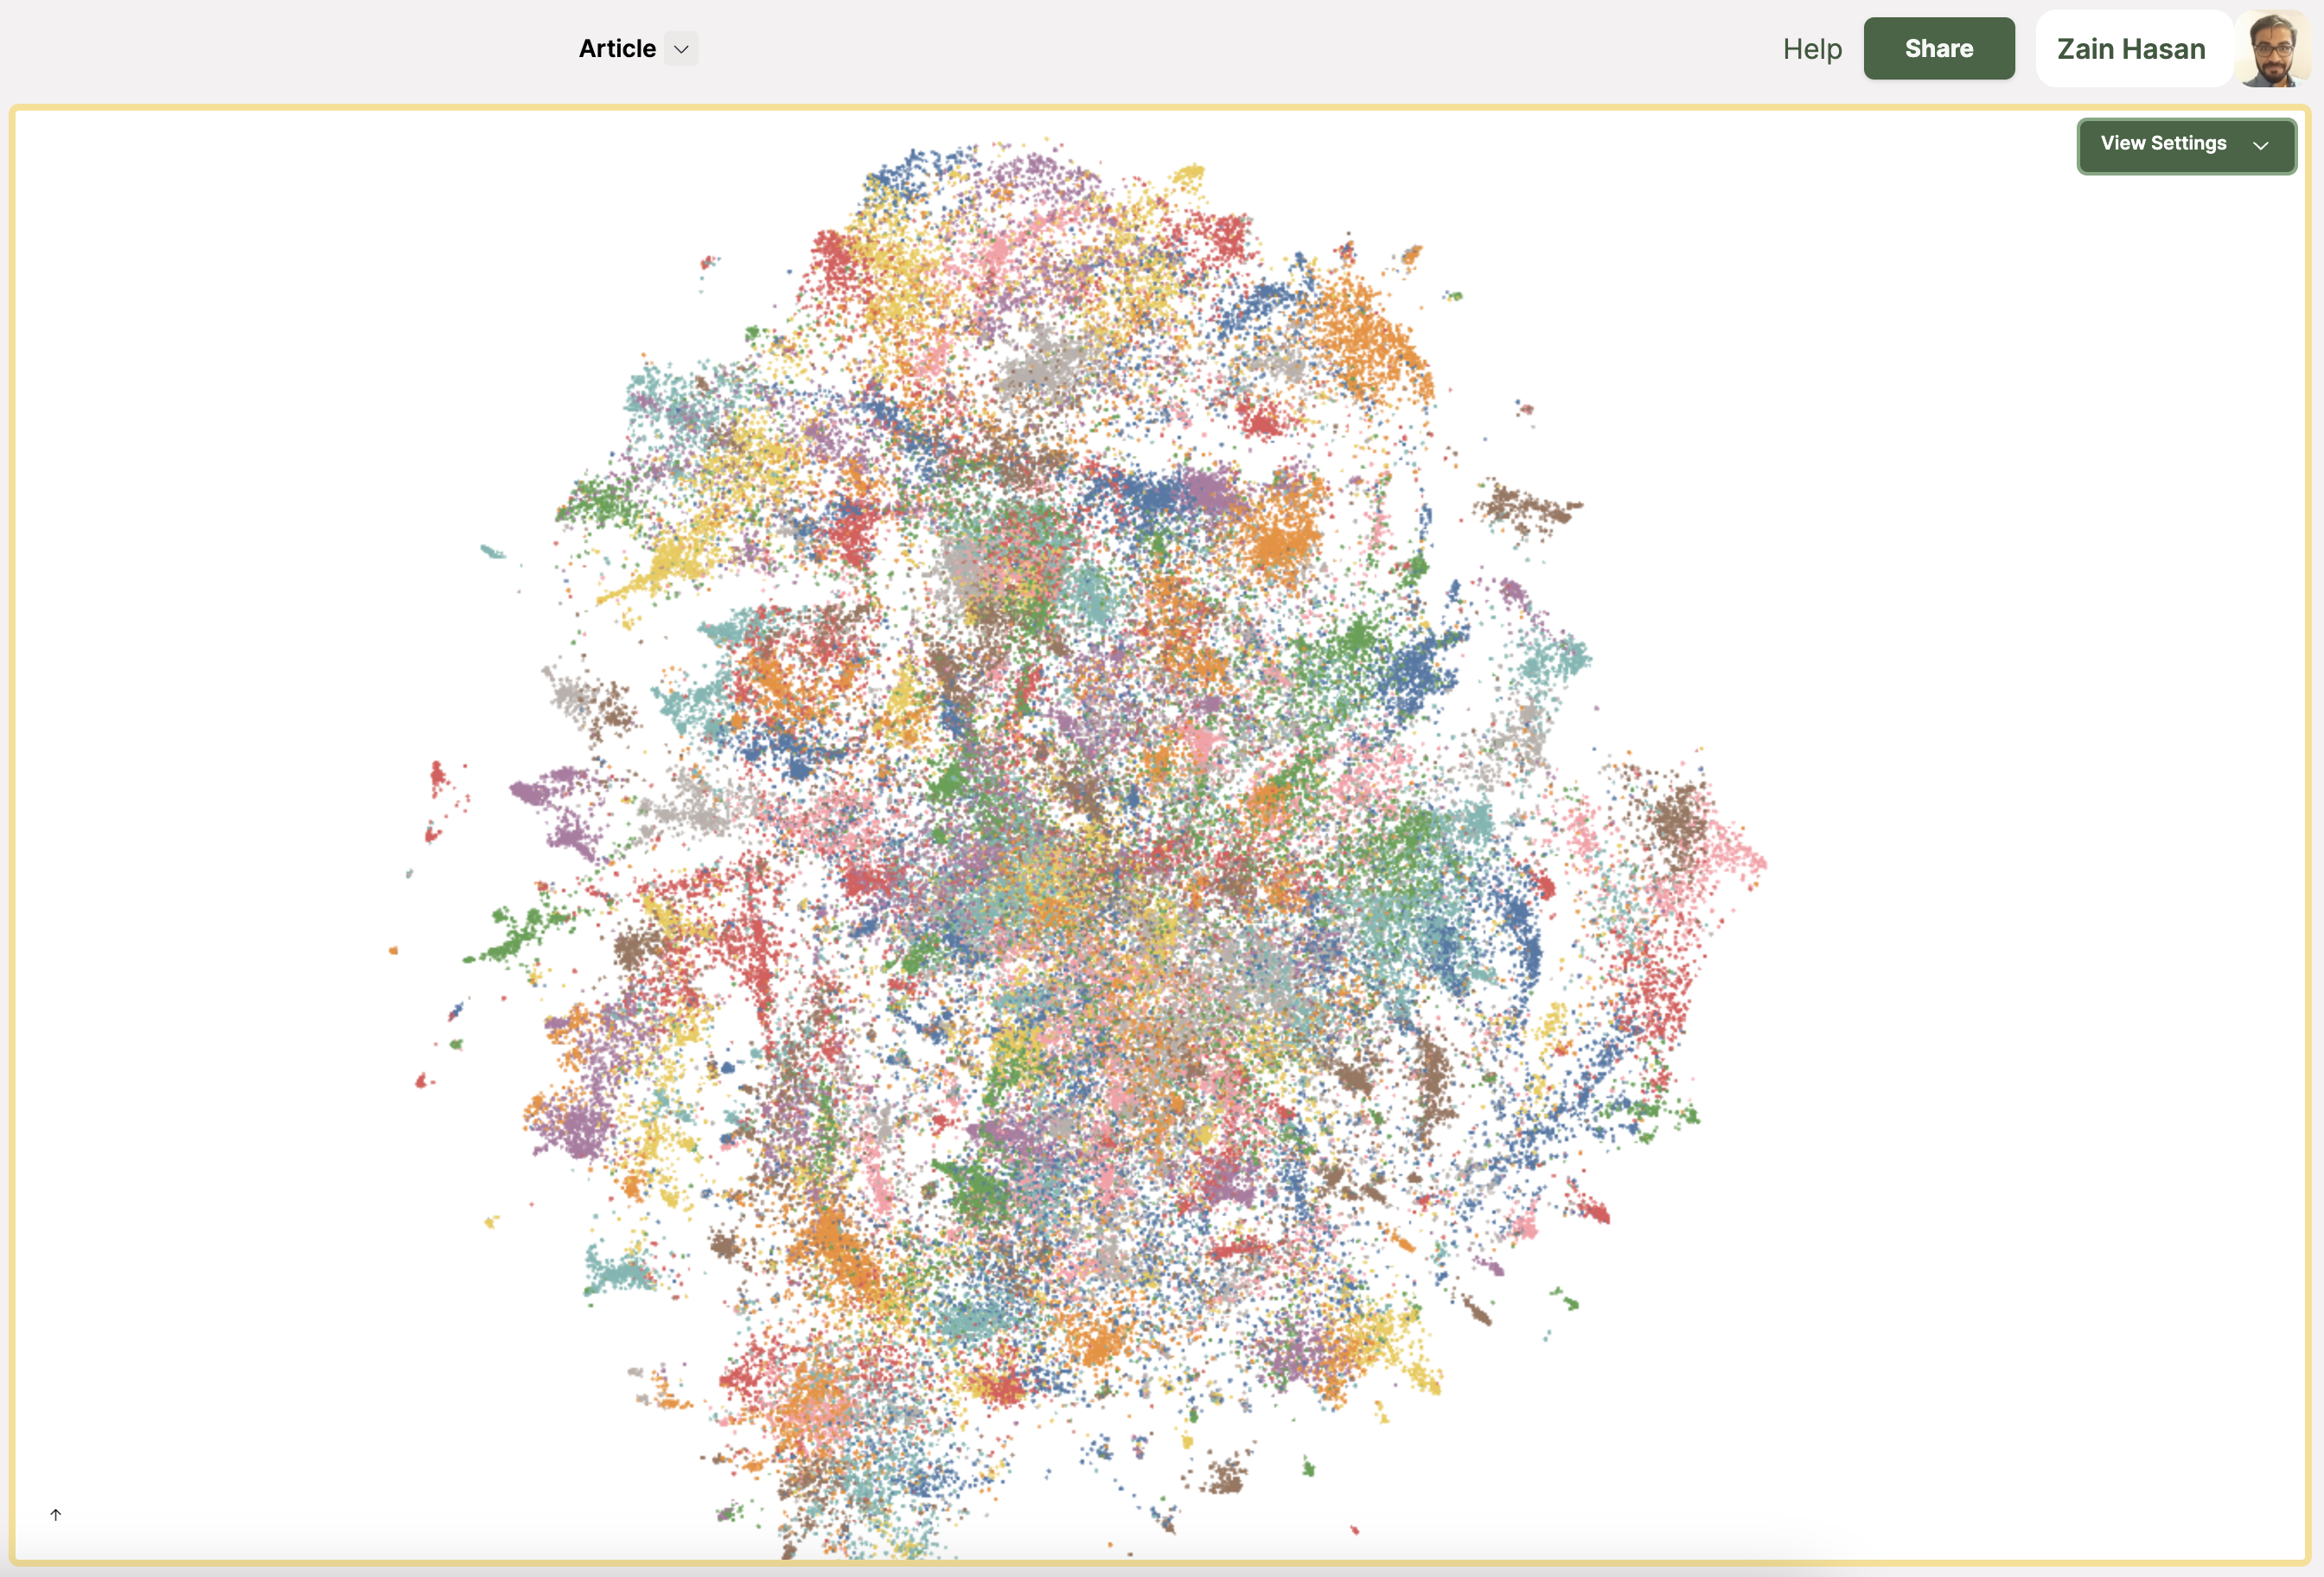


![](https://drive.google.com/open?id=1Fc9Nh8nthSgF2aiPB6m4lzs4oCTxAxp)